# Digital Shadows in Julia

This tutorial demonstrates how to create and work with digital shadows for CO₂ storage monitoring using Julia. We'll use ensemble-based data assimilation to combine physical models with real-time observations.

## Introduction to digital shadows

A digital shadow is a virtual representation of a physical system that is updated with real data. In the context of CO₂ storage, our digital shadow will:

1. Simulate CO₂ plume migration in the subsurface
2. Incorporate seismic monitoring data
3. Update predictions based on observations

## Setup and Installation

First, we'll install and load the required packages. This tutorial uses:

- JutulDarcy: for CO₂ flow simulation
- JUDI: for seismic modeling
- CairoMakie: For visualization
- JLD2: for saving data
- DrWatson: for ease of saving and accessing data
- Other utility packages
- Scripts for data assimilation

But it also uses packages that Grant is currently developing to facilitate our digital twins research:

- [Ensembles.jl]
- [EnsembleKalmanFilters.jl]
- [ConfigurationsJutulDarcy.jl]
- [JutulJUDIFilter.jl]

Since these unreleased packages are not in the Julia package registry, we here use an `install.jl` script to add them by url.

[Ensembles.jl]: [https://github.com/DataAssimilation/Ensembles.jl]
[EnsembleKalmanFilters.jl]: [https://github.com/DataAssimilation/EnsembleKalmanFilters.jl]
[ConfigurationsJutulDarcy.jl]: [https://github.com/DataAssimilation/ConfigurationsJutulDarcy.jl]
[JutulJUDIFilter.jl]: [https://github.com/DataAssimilation/JutulJUDIFilter.jl]

In [1]:
using Pkg
Pkg.activate("./")
ENV["jutuljudifilter_force_install"] = "true"
include("scripts/install.jl")
ENV["jutuljudifilter_force_install"] = "false";
Base.active_project()

"/home/gbruer/a/r/tmp2/05-Digital-Twins/Project.toml"

In [2]:
include("scripts/generate_ground_truth.jl")
include("scripts/generate_initial_ensemble.jl")
include("scripts/run_estimator.jl")
using CairoMakie
using JutulJUDIFilter
using JLD2

## Mathematical Framework

Our digital twin system is based on two key components:

1. **State evolution**: The system state $x$ evolves over time according to the transition operator $\mathcal{M}$ such that
   $x_{t+1} = \mathcal{M}(x_t)$

2. **Observations**: We observe the state indirectly through measurements $y$ using the observation operator $\mathcal{H}$ such that
   $y_t = \mathcal{H}(x_t)$

### CO₂ plume physics

The transition operator $\mathcal{M}$ models:
- Two-phase flow (CO₂ and water)
- Pressure evolution
- Density and viscosity effects
- Permeability and porosity influences

See `src/jutul_model.jl` for the interface we use to set up and call JutulDarcy for simulating the fluid flow.

### Seismic monitoring

The observation operator $\mathcal{H}$ represents:
- Seismic wave propagation
- Rock physics relationships
- Acquisition geometry

See `src/seismic_model.jl` for the interface we use to set up and call JUDI.

## Generate Ground Truth Data

We'll create synthetic data to represent the "true" system we want to monitor. This includes:
1. A permeability field
2. CO₂ injection scenario
3. Resulting seismic observations

We can print out a readable format of the ground-truth params as YAML.

In [3]:
params = include("params/tutorial-params.jl")
filestem = "tutorial"

params_gt = params.ground_truth

params_file = datadir("ground_truth", "params", "$filestem.jld2")
wsave(params_file; params=params_gt)

params_file = datadir("ground_truth", "params", "$filestem-human.yaml")
YAML.write_file(params_file, to_dict(params_gt, YAMLStyle))

### Transition parameters

In [4]:
println(YAML.write(to_dict(params_gt.transition, YAMLStyle)))

mesh:
  n: (75, 1, 75)
  d: (55, 100.0, 25)
  origin: (0.0, 0.0, 0.0)
nt: 25
system:
  viscosity_CO2: 0.0001
  viscosity_H2O: 0.001
  density_CO2: 501.9
  density_H2O: 1053.0
  reference_pressure: 1.5e7
  compressibility_CO2: 8.0e-9
  compressibility_H2O: 3.6563071e-10
  extra_kwargs: NamedTuple()
dt: 73.0485
nbatches: 1
kv_over_kh: 0.36
sat0_radius_cells: 4
sat0_range: (0.2, 0.8)
fluid1:
  name: "H₂O"
  viscosity: 0.001
  density: 1053.0
  compressibility: 3.6563071e-10
fluid2:
  name: "CO₂"
  viscosity: 0.0001
  density: 776.6
  compressibility: 8.0e-9
g: 9.81
reference_pressure: 1.5e7
porosity:
  name: field
  suboptions:
    value: 0.25
permeability:
  name: field
  suboptions:
    file: "/opt/SLIM-Storage/compass_small/perm_poro.jld2"
    idx: ~
    key: "K"
    scale: 9.86923266716013e-16
    resize: true
permeability_v_over_h: 0.36
temperature:
  name: field
  suboptions:
    value: 303.15
rock_density:
  name: field
  suboptions:
    value: 30.0
rock_heat_capacity:
  name: fiel

### Observation parameters

In [5]:
println("Observation times (seconds): $([o.first for o in params_gt.observation.observers])")
println()
println(YAML.write(to_dict(params_gt.observation.observers[1].second, YAMLStyle)))

Observation times (seconds): [0.0, 3.1556952e7, 6.3113904e7, 9.4670856e7]

seismic:
  velocity: (type = :squared_slowness, field = FieldOptions(:field, FieldFileOptions("/opt/SLIM-Storage/compass_small/BGCompass_tti_625m.jld2", nothing, "m", 1.0e-6, true)))
  density:
    name: field
    suboptions:
      file: "/opt/SLIM-Storage/compass_small/BGCompass_tti_625m.jld2"
      idx: ~
      key: "rho"
      scale: 1000.0
      resize: true
  mesh:
    n: (75, 75)
    d: (55, 25)
    origin: (0.0, 0.0, 0.0)
  type: born_shot_rtm_depth_noise
  background_velocity:
    cells: 10.0
  background_density:
    cells: 10.0
  nbl: 80
  timeR: 1800.0
  dtR: 4.0
  f0: 0.024
  source_receiver_geometry:
    nsrc: 4
    nrec: 50
    setup_type: surface
  depth_scaling_exponent: 1
  snr: 20.0
  seed: 13291501778007796644
rock_physics:
  density_CO2: 501.9
  density_H2O: 1053.0
  bulk_min: 3.66e10
  bulk_H2O: 2.735e9
  bulk_CO2: 1.25e8
  porosity:
    name: field
    suboptions:
      value: 0.25
save_int

### Simulate ground-truth transitions and observations

This code uses [DrWatson]'s `produce_or_load` functionality. It checks the given `filename` for the data, and if it doesn't exist, the data is generated with `generate_ground_truth` defined in `scripts/generate_ground_truth.jl`.

[DrWatson]: [https://juliadynamics.github.io/DrWatson.jl/stable/]

In [6]:
savedir = datadir("ground_truth", "data")
data_gt, filepath = produce_or_load(
    generate_ground_truth,
    params_gt,
    savedir;
    filename=filestem,
    verbose=true,
    force=false,
)
states = data_gt["states"]
observations = data_gt["observations"]
observations_clean = data_gt["observations_clean"]
state_times = data_gt["state_times"]
observation_times = data_gt["observation_times"];

110.667090 seconds (51.17 M allocations: 4.310 GiB, 33.86% gc time, 32.73% compilation time: 15% of which was recompilation)
  ^ timing for making ground truth data


## Visualize ground-truth data

Let's look at the generated data. First, we'll check some basic information about the data.

In [7]:
@show length(states)
println()
@show length(state_times)
println()
@show keys(states[1])
println()
@show keys(observations[1])
println()
@show length(observations)
println()
@show length(observation_times);

length(states) = 4

length(state_times) = 4

keys(states[1]) = [:Permeability, :Injector_Pressure, :Saturation, :Pressure, :Facility_TotalSurfaceMassRate, :Injector_Saturations]

keys(observations[1]) = [:dshot, :rtm]

length(observations) = 4

length(observation_times) = 4


### Prepare to plot.
This sets up the plotting library and gets mesh information we can use for plotting.

In [8]:
CairoMakie.activate!()
update_theme!(; fontsize=24)
function Makie.resize_to_layout!(fig, content_layout)
    Makie.update_state_before_display!(fig)
    bbox = Makie.GridLayoutBase.tight_bbox(content_layout)
    new_size = (widths(bbox)...,)
    resize!(fig.scene, widths(bbox)...)
end
grid_2d = get_2d_plotting_mesh(params_gt.transition.mesh)

(d = (0.055, 0.025), origin = (0.0, 0.0), n = (75, 75))

### Show ground-truth permeability

The permeability is a second-order diagonal tensor field. Here, we plot the lateral component of the permeability.

size(data) = (3, 5625)


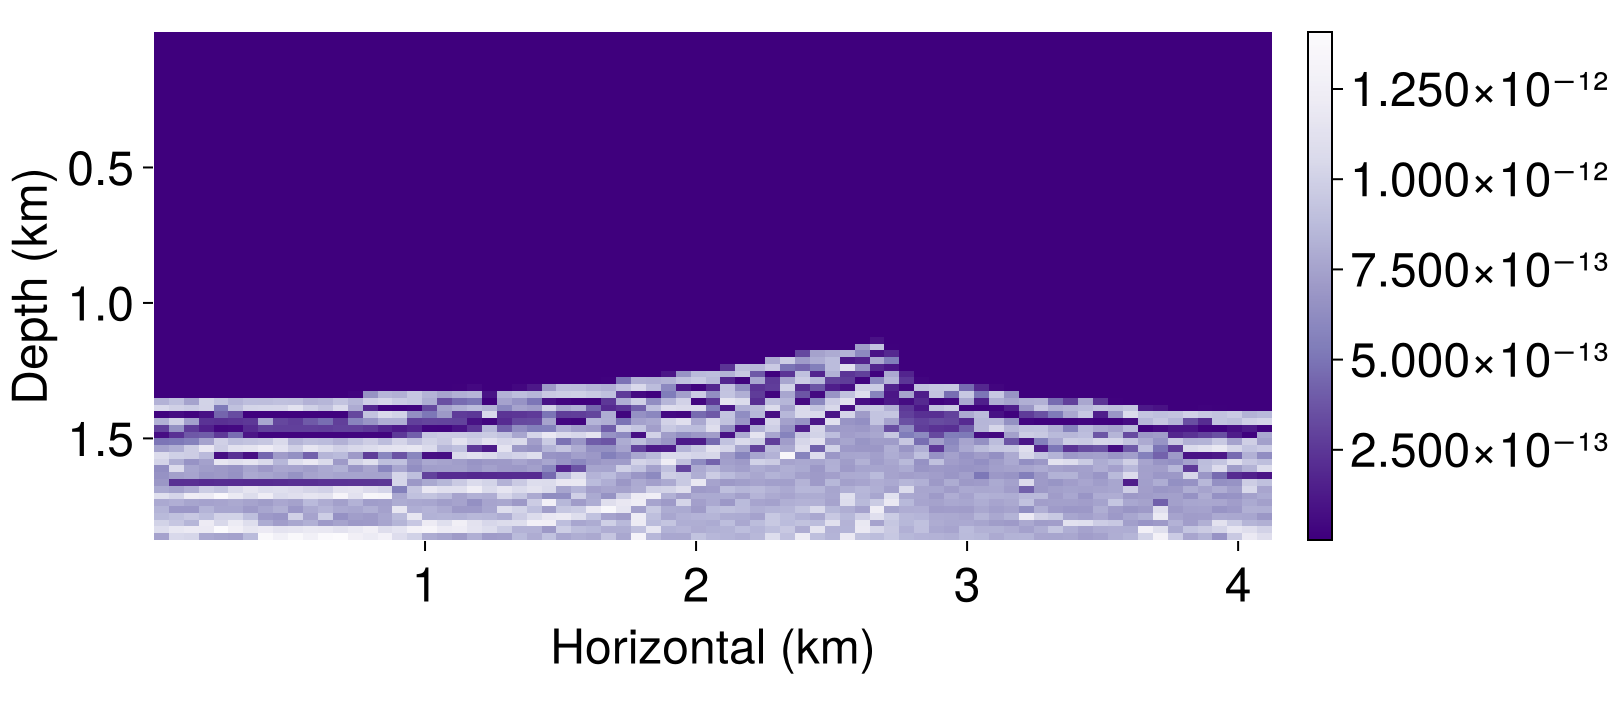

In [9]:
fig = Figure()
data = states[1][:Permeability]
@show size(data)
content_layout = GridLayout(fig[1,1])
plot_scalar_field(content_layout, Observable(data[1, :]); grid_2d, heatmap_kwargs=(; colormap=Reverse(:Purples)))
resize_to_layout!(fig, content_layout)
fig

### Show ground-truth plume over time
Here I use [Makie.jl] to easily visualize the time-dependent stats over time.

[Makie.jl]: [https://docs.makie.org/]

In [10]:
fig = Figure()
t_idx = Observable(1)
data = @lift(states[$t_idx][:Saturation])
content_layout = GridLayout(fig[1,1])
ax = plot_scalar_field(content_layout, data; grid_2d, heatmap_kwargs=(; colorrange=(0,1), colormap=parula))
    
label = lift(t_idx -> "Saturation at time step $(t_idx)", t_idx)
Label(fig[1,1, Top()], label)
resize_to_layout!(fig, content_layout)

Record(fig, 1:length(states); framerate = 1) do i
    t_idx[] = i
end

VideoStream(Base.PipeEndpoint(RawFD(53) open, 0 bytes waiting), Process(setenv(`/home/gbruer/.julia/artifacts/fdb14f7b1bf6766687af4e3951c4d982cee66086/bin/ffmpeg -y -loglevel quiet -threads 4 -framerate 1 -pixel_format rgb24 -f rawvideo -s:v 1486x648 -r 1 -i pipe:0 -vf vflip -profile:v high422 -crf 20 -preset slow -c:v libx264 -pix_fmt yuv420p -an '/tmp/jl_nrrRXE/##video#249.mp4'`,["VTE_VERSION=7600", "jutuljudifilter_force_install=false", "PATH=/home/gbruer/.julia/artifacts/2ab21f29b30c228bd0e5215585f822730cad5a72/bin:/home/gbruer/.julia/artifacts/cb697355f42d1d0c8f70b15c0c3dc28952f774b4/bin:/home/gbruer/.julia/artifacts/1308e48c3f4f2fd9adaa56b9bd4a86a995d50abd/bin:/home/gbruer/.julia/artifacts/558980a93131f08be5335521b84e137ee3172296/bin:/home/gbruer/.julia/artifacts/c8a20a2030f10b70947d8d2a6bff7f8b5f343fe9/bin:/home/gbruer/.julia/artifacts/1cf7375e8ec1bbe1219934488737c12237ba2012/bin:/home/gbruer/.julia/artifacts/aa47becfd7dbea936fcdbe2abc2c5637739026df/bin:/home/gbruer/.julia/artifacts/00023f2f62a04af7531278ce1a689ff93800ffa1/bin:/home/gbruer/.julia/artifacts/c951fb23b5652def1dea483af7095a38f3b3cefd/bin:/home/gbruer/.julia/artifacts/fdb14f7b1bf6766687af4e3951c4d982cee66086/bin:/home/gbruer/.julia/conda/3/x86_64/bin:/opt/nvidia/hpc_sdk/Linux_x86_64/24.9/compilers/bin:/usr/local/cuda/bin:/home/gbruer/.juliaup/bin:/home/gbruer/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/snap/bin\$", "QT_ACCESSIBILITY=1", "LD_LIBRARY_PATH=/home/gbruer/.julia/artifacts/f839432e3d2904a5c847b217ef0c0f489377ecc5/lib:/home/gbruer/.julia/juliaup/julia-1.10.6+0.x64.linux.gnu/bin/../lib/julia:/home/gbruer/.julia/artifacts/0803f8d074309498cdf55effdb9c55bc3ef88dde/lib:/home/gbruer/.julia/artifacts/2ab21f29b30c228bd0e5215585f822730cad5a72/lib:/home/gbruer/.julia/artifacts/2def0eca464bd6d89ccac85338474402359d4930/lib:/home/gbruer/.julia/artifacts/d00220164876dea2cb19993200662745eed5e2db/lib:/home/gbruer/.julia/artifacts/cb697355f42d1d0c8f70b15c0c3dc28952f774b4/lib:/home/gbruer/.julia/artifacts/dc526f26fb179a3f68eb13fcbe5d2d2a5aa7eeac/lib:/home/gbruer/.julia/artifacts/c9fd7a94d3c09eac4f3ca94d21bf40ccf65eccf5/lib:/home/gbruer/.julia/artifacts/b757190a3c47fcb65f573f631fdd549b98fcf2e4/lib:/home/gbruer/.julia/artifacts/b3ddd583e7aec92a77cf5961fad01fd7063c1d40/lib:/home/gbruer/.julia/artifacts/7099954ffb0b6e1641832a06a08e479498ce479f/lib:/home/gbruer/.julia/artifacts/f92cfdafb94fa8c50330be3684c9aeb80bd14750/lib:/home/gbruer/.julia/artifacts/1308e48c3f4f2fd9adaa56b9bd4a86a995d50abd/lib:/home/gbruer/.julia/artifacts/558980a93131f08be5335521b84e137ee3172296/lib:/home/gbruer/.julia/artifacts/d75cfbd8954fdbc933ebead40a9c8b91513c023a/lib:/home/gbruer/.julia/artifacts/9cfb24edca23321a2dcebb63b4e196181359ecd6/lib:/home/gbruer/.julia/artifacts/aae093c71ea1b1dc04c457afcae880d26c532115/lib:/home/gbruer/.julia/artifacts/bd965e3c7f9460155f06361da380c63fa0351ef6/lib:/home/gbruer/.julia/artifacts/060cf7829c3363638c29228ea4ab0bd033d8eab0/lib:/home/gbruer/.julia/artifacts/77d0e7c90e6a2fd6f2f8457bbb7b86ed86d140d9/lib:/home/gbruer/.julia/artifacts/1e69ef9fbf05e2896d3cb70eac8080c4d10f8696/lib:/home/gbruer/.julia/artifacts/e200b9737b27598b95b404cbc34e74f95b2bf5d0/lib:/home/gbruer/.julia/artifacts/a8e2d77aed043a035fd970326d8f070080efa8fa/lib:/home/gbruer/.julia/artifacts/6f98018cad6a09e91f90658f188c6be47e48a0c7/lib:/home/gbruer/.julia/artifacts/d4f3ff9736df0dda120f8dc1d27174b0d5696fb1/lib:/home/gbruer/.julia/artifacts/62c010876222f83fe8878bf2af0e362083d20ee3/lib:/home/gbruer/.julia/artifacts/75b657b876788e58671ab6b88e49019aa36b67cd/lib:/home/gbruer/.julia/artifacts/bd1f25e7053ebc00ee7d82f3c5ec4cf1e9a51e17/lib:/home/gbruer/.julia/artifacts/cf5d5f8a6109be3f9c460a39768f57a3e53ff11d/lib:/home/gbruer/.julia/artifacts/c8a20a2030f10b70947d8d2a6bff7f8b5f343fe9/lib:/home/gbruer/.julia/artifacts/0631e2a6a31b5692eec7a575836451b16b734ec0/lib:/home/gbruer/.julia/artifacts/4abd0521d210cb9e48ea5e711873ba34dc05fc70/lib:/home/gbruer/

In [11]:
fig = Figure()
t_idx = Observable(1)
data = @lift(states[$t_idx][:Pressure] .- states[1][:Pressure])
content_layout = GridLayout(fig[1,1])
plot_scalar_field(content_layout, data; grid_2d, heatmap_kwargs=(; make_divergent=true, colormap=Reverse(:RdBu)))
    
label = lift(t_idx -> "Pressure difference at time step $(t_idx)", t_idx)
Label(fig[1,1, Top()], label)
resize_to_layout!(fig, content_layout)

Record(fig, 1:length(states); framerate = 1) do i
    t_idx[] = i
end

VideoStream(Base.PipeEndpoint(RawFD(53) open, 0 bytes waiting), Process(setenv(`/home/gbruer/.julia/artifacts/fdb14f7b1bf6766687af4e3951c4d982cee66086/bin/ffmpeg -y -loglevel quiet -threads 4 -framerate 1 -pixel_format rgb24 -f rawvideo -s:v 1486x648 -r 1 -i pipe:0 -vf vflip -profile:v high422 -crf 20 -preset slow -c:v libx264 -pix_fmt yuv420p -an '/tmp/jl_RUNl2n/##video#251.mp4'`,["VTE_VERSION=7600", "jutuljudifilter_force_install=false", "PATH=/home/gbruer/.julia/artifacts/2ab21f29b30c228bd0e5215585f822730cad5a72/bin:/home/gbruer/.julia/artifacts/cb697355f42d1d0c8f70b15c0c3dc28952f774b4/bin:/home/gbruer/.julia/artifacts/1308e48c3f4f2fd9adaa56b9bd4a86a995d50abd/bin:/home/gbruer/.julia/artifacts/558980a93131f08be5335521b84e137ee3172296/bin:/home/gbruer/.julia/artifacts/c8a20a2030f10b70947d8d2a6bff7f8b5f343fe9/bin:/home/gbruer/.julia/artifacts/1cf7375e8ec1bbe1219934488737c12237ba2012/bin:/home/gbruer/.julia/artifacts/aa47becfd7dbea936fcdbe2abc2c5637739026df/bin:/home/gbruer/.julia/artifacts/00023f2f62a04af7531278ce1a689ff93800ffa1/bin:/home/gbruer/.julia/artifacts/c951fb23b5652def1dea483af7095a38f3b3cefd/bin:/home/gbruer/.julia/artifacts/fdb14f7b1bf6766687af4e3951c4d982cee66086/bin:/home/gbruer/.julia/conda/3/x86_64/bin:/opt/nvidia/hpc_sdk/Linux_x86_64/24.9/compilers/bin:/usr/local/cuda/bin:/home/gbruer/.juliaup/bin:/home/gbruer/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/snap/bin\$", "QT_ACCESSIBILITY=1", "LD_LIBRARY_PATH=/home/gbruer/.julia/artifacts/f839432e3d2904a5c847b217ef0c0f489377ecc5/lib:/home/gbruer/.julia/juliaup/julia-1.10.6+0.x64.linux.gnu/bin/../lib/julia:/home/gbruer/.julia/artifacts/0803f8d074309498cdf55effdb9c55bc3ef88dde/lib:/home/gbruer/.julia/artifacts/2ab21f29b30c228bd0e5215585f822730cad5a72/lib:/home/gbruer/.julia/artifacts/2def0eca464bd6d89ccac85338474402359d4930/lib:/home/gbruer/.julia/artifacts/d00220164876dea2cb19993200662745eed5e2db/lib:/home/gbruer/.julia/artifacts/cb697355f42d1d0c8f70b15c0c3dc28952f774b4/lib:/home/gbruer/.julia/artifacts/dc526f26fb179a3f68eb13fcbe5d2d2a5aa7eeac/lib:/home/gbruer/.julia/artifacts/c9fd7a94d3c09eac4f3ca94d21bf40ccf65eccf5/lib:/home/gbruer/.julia/artifacts/b757190a3c47fcb65f573f631fdd549b98fcf2e4/lib:/home/gbruer/.julia/artifacts/b3ddd583e7aec92a77cf5961fad01fd7063c1d40/lib:/home/gbruer/.julia/artifacts/7099954ffb0b6e1641832a06a08e479498ce479f/lib:/home/gbruer/.julia/artifacts/f92cfdafb94fa8c50330be3684c9aeb80bd14750/lib:/home/gbruer/.julia/artifacts/1308e48c3f4f2fd9adaa56b9bd4a86a995d50abd/lib:/home/gbruer/.julia/artifacts/558980a93131f08be5335521b84e137ee3172296/lib:/home/gbruer/.julia/artifacts/d75cfbd8954fdbc933ebead40a9c8b91513c023a/lib:/home/gbruer/.julia/artifacts/9cfb24edca23321a2dcebb63b4e196181359ecd6/lib:/home/gbruer/.julia/artifacts/aae093c71ea1b1dc04c457afcae880d26c532115/lib:/home/gbruer/.julia/artifacts/bd965e3c7f9460155f06361da380c63fa0351ef6/lib:/home/gbruer/.julia/artifacts/060cf7829c3363638c29228ea4ab0bd033d8eab0/lib:/home/gbruer/.julia/artifacts/77d0e7c90e6a2fd6f2f8457bbb7b86ed86d140d9/lib:/home/gbruer/.julia/artifacts/1e69ef9fbf05e2896d3cb70eac8080c4d10f8696/lib:/home/gbruer/.julia/artifacts/e200b9737b27598b95b404cbc34e74f95b2bf5d0/lib:/home/gbruer/.julia/artifacts/a8e2d77aed043a035fd970326d8f070080efa8fa/lib:/home/gbruer/.julia/artifacts/6f98018cad6a09e91f90658f188c6be47e48a0c7/lib:/home/gbruer/.julia/artifacts/d4f3ff9736df0dda120f8dc1d27174b0d5696fb1/lib:/home/gbruer/.julia/artifacts/62c010876222f83fe8878bf2af0e362083d20ee3/lib:/home/gbruer/.julia/artifacts/75b657b876788e58671ab6b88e49019aa36b67cd/lib:/home/gbruer/.julia/artifacts/bd1f25e7053ebc00ee7d82f3c5ec4cf1e9a51e17/lib:/home/gbruer/.julia/artifacts/cf5d5f8a6109be3f9c460a39768f57a3e53ff11d/lib:/home/gbruer/.julia/artifacts/c8a20a2030f10b70947d8d2a6bff7f8b5f343fe9/lib:/home/gbruer/.julia/artifacts/0631e2a6a31b5692eec7a575836451b16b734ec0/lib:/home/gbruer/.julia/artifacts/4abd0521d210cb9e48ea5e711873ba34dc05fc70/lib:/home/gbruer/

In [12]:
fig = Figure()
t_idx = Observable(1)
data = @lift(observations[$t_idx][:rtm] .- observations[1][:rtm])
content_layout = GridLayout(fig[1,1])
plot_scalar_field(content_layout, data; grid_2d, heatmap_kwargs=(; make_divergent=true, colormap=Reverse(:RdBu)))
    
label = lift(t_idx -> "Time-lapse RTM at time step $(t_idx)", t_idx)
Label(fig[1,1, Top()], label)
resize_to_layout!(fig, content_layout)

Record(fig, 1:length(states); framerate = 1) do i
    t_idx[] = i
end

VideoStream(Base.PipeEndpoint(RawFD(53) open, 0 bytes waiting), Process(setenv(`/home/gbruer/.julia/artifacts/fdb14f7b1bf6766687af4e3951c4d982cee66086/bin/ffmpeg -y -loglevel quiet -threads 4 -framerate 1 -pixel_format rgb24 -f rawvideo -s:v 1486x648 -r 1 -i pipe:0 -vf vflip -profile:v high422 -crf 20 -preset slow -c:v libx264 -pix_fmt yuv420p -an '/tmp/jl_rqiQWf/##video#253.mp4'`,["VTE_VERSION=7600", "jutuljudifilter_force_install=false", "PATH=/home/gbruer/.julia/artifacts/2ab21f29b30c228bd0e5215585f822730cad5a72/bin:/home/gbruer/.julia/artifacts/cb697355f42d1d0c8f70b15c0c3dc28952f774b4/bin:/home/gbruer/.julia/artifacts/1308e48c3f4f2fd9adaa56b9bd4a86a995d50abd/bin:/home/gbruer/.julia/artifacts/558980a93131f08be5335521b84e137ee3172296/bin:/home/gbruer/.julia/artifacts/c8a20a2030f10b70947d8d2a6bff7f8b5f343fe9/bin:/home/gbruer/.julia/artifacts/1cf7375e8ec1bbe1219934488737c12237ba2012/bin:/home/gbruer/.julia/artifacts/aa47becfd7dbea936fcdbe2abc2c5637739026df/bin:/home/gbruer/.julia/artifacts/00023f2f62a04af7531278ce1a689ff93800ffa1/bin:/home/gbruer/.julia/artifacts/c951fb23b5652def1dea483af7095a38f3b3cefd/bin:/home/gbruer/.julia/artifacts/fdb14f7b1bf6766687af4e3951c4d982cee66086/bin:/home/gbruer/.julia/conda/3/x86_64/bin:/opt/nvidia/hpc_sdk/Linux_x86_64/24.9/compilers/bin:/usr/local/cuda/bin:/home/gbruer/.juliaup/bin:/home/gbruer/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/snap/bin\$", "QT_ACCESSIBILITY=1", "LD_LIBRARY_PATH=/home/gbruer/.julia/artifacts/f839432e3d2904a5c847b217ef0c0f489377ecc5/lib:/home/gbruer/.julia/juliaup/julia-1.10.6+0.x64.linux.gnu/bin/../lib/julia:/home/gbruer/.julia/artifacts/0803f8d074309498cdf55effdb9c55bc3ef88dde/lib:/home/gbruer/.julia/artifacts/2ab21f29b30c228bd0e5215585f822730cad5a72/lib:/home/gbruer/.julia/artifacts/2def0eca464bd6d89ccac85338474402359d4930/lib:/home/gbruer/.julia/artifacts/d00220164876dea2cb19993200662745eed5e2db/lib:/home/gbruer/.julia/artifacts/cb697355f42d1d0c8f70b15c0c3dc28952f774b4/lib:/home/gbruer/.julia/artifacts/dc526f26fb179a3f68eb13fcbe5d2d2a5aa7eeac/lib:/home/gbruer/.julia/artifacts/c9fd7a94d3c09eac4f3ca94d21bf40ccf65eccf5/lib:/home/gbruer/.julia/artifacts/b757190a3c47fcb65f573f631fdd549b98fcf2e4/lib:/home/gbruer/.julia/artifacts/b3ddd583e7aec92a77cf5961fad01fd7063c1d40/lib:/home/gbruer/.julia/artifacts/7099954ffb0b6e1641832a06a08e479498ce479f/lib:/home/gbruer/.julia/artifacts/f92cfdafb94fa8c50330be3684c9aeb80bd14750/lib:/home/gbruer/.julia/artifacts/1308e48c3f4f2fd9adaa56b9bd4a86a995d50abd/lib:/home/gbruer/.julia/artifacts/558980a93131f08be5335521b84e137ee3172296/lib:/home/gbruer/.julia/artifacts/d75cfbd8954fdbc933ebead40a9c8b91513c023a/lib:/home/gbruer/.julia/artifacts/9cfb24edca23321a2dcebb63b4e196181359ecd6/lib:/home/gbruer/.julia/artifacts/aae093c71ea1b1dc04c457afcae880d26c532115/lib:/home/gbruer/.julia/artifacts/bd965e3c7f9460155f06361da380c63fa0351ef6/lib:/home/gbruer/.julia/artifacts/060cf7829c3363638c29228ea4ab0bd033d8eab0/lib:/home/gbruer/.julia/artifacts/77d0e7c90e6a2fd6f2f8457bbb7b86ed86d140d9/lib:/home/gbruer/.julia/artifacts/1e69ef9fbf05e2896d3cb70eac8080c4d10f8696/lib:/home/gbruer/.julia/artifacts/e200b9737b27598b95b404cbc34e74f95b2bf5d0/lib:/home/gbruer/.julia/artifacts/a8e2d77aed043a035fd970326d8f070080efa8fa/lib:/home/gbruer/.julia/artifacts/6f98018cad6a09e91f90658f188c6be47e48a0c7/lib:/home/gbruer/.julia/artifacts/d4f3ff9736df0dda120f8dc1d27174b0d5696fb1/lib:/home/gbruer/.julia/artifacts/62c010876222f83fe8878bf2af0e362083d20ee3/lib:/home/gbruer/.julia/artifacts/75b657b876788e58671ab6b88e49019aa36b67cd/lib:/home/gbruer/.julia/artifacts/bd1f25e7053ebc00ee7d82f3c5ec4cf1e9a51e17/lib:/home/gbruer/.julia/artifacts/cf5d5f8a6109be3f9c460a39768f57a3e53ff11d/lib:/home/gbruer/.julia/artifacts/c8a20a2030f10b70947d8d2a6bff7f8b5f343fe9/lib:/home/gbruer/.julia/artifacts/0631e2a6a31b5692eec7a575836451b16b734ec0/lib:/home/gbruer/.julia/artifacts/4abd0521d210cb9e48ea5e711873ba34dc05fc70/lib:/home/gbruer/

In [13]:
fig = Figure(; size=(1000, 520))
t_idx = Observable(1)
function dshot_diff(state)
    return [d .- d0 for (d0, d) in zip(observations[1][:dshot], state[:dshot])]
end
data = @lift(dshot_diff(observations[$t_idx]))
content_layout = GridLayout(fig[1,1])
timeR = @lift(params_gt.observation.observers[$t_idx].second.seismic.timeR)
dtR = @lift(params_gt.observation.observers[$t_idx].second.seismic.dtR)
nsrc = params_gt.observation.observers[1].second.seismic.source_receiver_geometry.nsrc
plot_data(content_layout, data, nothing, :dshot; heatmap_kwargs=(; make_divergent=true, colormap=Reverse(:RdBu)), nsrc, timeR, dtR)
    
label = lift(t_idx -> "Time-lapse shot data at time step $(t_idx)", t_idx)
Label(fig[1,1, Top()], label)
resize_to_layout!(fig, content(content_layout[1, 1][2, 1]))

Record(fig, 1:length(states); framerate = 1) do i
    t_idx[] = i
end

VideoStream(Base.PipeEndpoint(RawFD(53) open, 0 bytes waiting), Process(setenv(`/home/gbruer/.julia/artifacts/fdb14f7b1bf6766687af4e3951c4d982cee66086/bin/ffmpeg -y -loglevel quiet -threads 4 -framerate 1 -pixel_format rgb24 -f rawvideo -s:v 2286x732 -r 1 -i pipe:0 -vf vflip -profile:v high422 -crf 20 -preset slow -c:v libx264 -pix_fmt yuv420p -an '/tmp/jl_1mgVRN/##video#257.mp4'`,["VTE_VERSION=7600", "jutuljudifilter_force_install=false", "PATH=/home/gbruer/.julia/artifacts/2ab21f29b30c228bd0e5215585f822730cad5a72/bin:/home/gbruer/.julia/artifacts/cb697355f42d1d0c8f70b15c0c3dc28952f774b4/bin:/home/gbruer/.julia/artifacts/1308e48c3f4f2fd9adaa56b9bd4a86a995d50abd/bin:/home/gbruer/.julia/artifacts/558980a93131f08be5335521b84e137ee3172296/bin:/home/gbruer/.julia/artifacts/c8a20a2030f10b70947d8d2a6bff7f8b5f343fe9/bin:/home/gbruer/.julia/artifacts/1cf7375e8ec1bbe1219934488737c12237ba2012/bin:/home/gbruer/.julia/artifacts/aa47becfd7dbea936fcdbe2abc2c5637739026df/bin:/home/gbruer/.julia/artifacts/00023f2f62a04af7531278ce1a689ff93800ffa1/bin:/home/gbruer/.julia/artifacts/c951fb23b5652def1dea483af7095a38f3b3cefd/bin:/home/gbruer/.julia/artifacts/fdb14f7b1bf6766687af4e3951c4d982cee66086/bin:/home/gbruer/.julia/conda/3/x86_64/bin:/opt/nvidia/hpc_sdk/Linux_x86_64/24.9/compilers/bin:/usr/local/cuda/bin:/home/gbruer/.juliaup/bin:/home/gbruer/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/snap/bin\$", "QT_ACCESSIBILITY=1", "LD_LIBRARY_PATH=/home/gbruer/.julia/artifacts/f839432e3d2904a5c847b217ef0c0f489377ecc5/lib:/home/gbruer/.julia/juliaup/julia-1.10.6+0.x64.linux.gnu/bin/../lib/julia:/home/gbruer/.julia/artifacts/0803f8d074309498cdf55effdb9c55bc3ef88dde/lib:/home/gbruer/.julia/artifacts/2ab21f29b30c228bd0e5215585f822730cad5a72/lib:/home/gbruer/.julia/artifacts/2def0eca464bd6d89ccac85338474402359d4930/lib:/home/gbruer/.julia/artifacts/d00220164876dea2cb19993200662745eed5e2db/lib:/home/gbruer/.julia/artifacts/cb697355f42d1d0c8f70b15c0c3dc28952f774b4/lib:/home/gbruer/.julia/artifacts/dc526f26fb179a3f68eb13fcbe5d2d2a5aa7eeac/lib:/home/gbruer/.julia/artifacts/c9fd7a94d3c09eac4f3ca94d21bf40ccf65eccf5/lib:/home/gbruer/.julia/artifacts/b757190a3c47fcb65f573f631fdd549b98fcf2e4/lib:/home/gbruer/.julia/artifacts/b3ddd583e7aec92a77cf5961fad01fd7063c1d40/lib:/home/gbruer/.julia/artifacts/7099954ffb0b6e1641832a06a08e479498ce479f/lib:/home/gbruer/.julia/artifacts/f92cfdafb94fa8c50330be3684c9aeb80bd14750/lib:/home/gbruer/.julia/artifacts/1308e48c3f4f2fd9adaa56b9bd4a86a995d50abd/lib:/home/gbruer/.julia/artifacts/558980a93131f08be5335521b84e137ee3172296/lib:/home/gbruer/.julia/artifacts/d75cfbd8954fdbc933ebead40a9c8b91513c023a/lib:/home/gbruer/.julia/artifacts/9cfb24edca23321a2dcebb63b4e196181359ecd6/lib:/home/gbruer/.julia/artifacts/aae093c71ea1b1dc04c457afcae880d26c532115/lib:/home/gbruer/.julia/artifacts/bd965e3c7f9460155f06361da380c63fa0351ef6/lib:/home/gbruer/.julia/artifacts/060cf7829c3363638c29228ea4ab0bd033d8eab0/lib:/home/gbruer/.julia/artifacts/77d0e7c90e6a2fd6f2f8457bbb7b86ed86d140d9/lib:/home/gbruer/.julia/artifacts/1e69ef9fbf05e2896d3cb70eac8080c4d10f8696/lib:/home/gbruer/.julia/artifacts/e200b9737b27598b95b404cbc34e74f95b2bf5d0/lib:/home/gbruer/.julia/artifacts/a8e2d77aed043a035fd970326d8f070080efa8fa/lib:/home/gbruer/.julia/artifacts/6f98018cad6a09e91f90658f188c6be47e48a0c7/lib:/home/gbruer/.julia/artifacts/d4f3ff9736df0dda120f8dc1d27174b0d5696fb1/lib:/home/gbruer/.julia/artifacts/62c010876222f83fe8878bf2af0e362083d20ee3/lib:/home/gbruer/.julia/artifacts/75b657b876788e58671ab6b88e49019aa36b67cd/lib:/home/gbruer/.julia/artifacts/bd1f25e7053ebc00ee7d82f3c5ec4cf1e9a51e17/lib:/home/gbruer/.julia/artifacts/cf5d5f8a6109be3f9c460a39768f57a3e53ff11d/lib:/home/gbruer/.julia/artifacts/c8a20a2030f10b70947d8d2a6bff7f8b5f343fe9/lib:/home/gbruer/.julia/artifacts/0631e2a6a31b5692eec7a575836451b16b734ec0/lib:/home/gbruer/.julia/artifacts/4abd0521d210cb9e48ea5e711873ba34dc05fc70/lib:/home/gbruer/

## Generate initial ensemble

First, we'll look at the parameters for this script.

In [14]:
params_file = datadir("initial_ensemble", "params", "$filestem.jld2")
wsave(params_file; params=params.ensemble)

params_file = datadir("initial_ensemble", "params", "$filestem-human.yaml")
YAML.write_file(params_file, to_dict(params.ensemble, YAMLStyle))

println(YAML.write(to_dict(params.ensemble, YAMLStyle)))

version: "v0.1"
size: 4
seed: 9347215
mesh:
  n: (75, 1, 75)
  d: (55, 100.0, 25)
  origin: (0.0, 0.0, 0.0)
permeability_v_over_h: 0.36
prior: (Saturation = GaussianPriorOptions(0, 0), Permeability = FieldOptions(:field, FieldFileOptions("/opt/SLIM-Storage/compass_small/perm_poro.jld2", nothing, "Ks", 9.86923266716013e-16, true)))



### Run generation code
This code again uses DrWatson's `produce_or_load` functionality to avoid building the ensemble unnecessarily.

In [15]:
savedir = datadir("initial_ensemble", "data")
data_initial, filepath = produce_or_load(
    generate_initial_ensemble,
    params.ensemble,
    savedir;
    filename=filestem,
    verbose=false,
    loadfile=true,
)
ensemble = data_initial["ensemble"];

## Visualize initial ensemble data

Let's look at the generated data. First, we'll check some basic information about the data.

In [16]:
@show length(ensemble.members)
println()
@show keys(ensemble.members[1]);

length(ensemble.members) = 4

keys(ensemble.members[1]) = [:Permeability, :Saturation]


### Visualize ensemble permeabilities

In [17]:
fig = Figure()
e_idx = Observable(1)
data = @lift(ensemble.members[$e_idx][:Permeability][1, :])
content_layout = GridLayout(fig[1,1])
plot_scalar_field(content_layout, data; grid_2d, heatmap_kwargs=(; colormap=Reverse(:Purples)))
    
label = lift(e_idx -> "Permeability sample $(e_idx)", e_idx)
Label(fig[1,1, Top()], label)
resize_to_layout!(fig, content_layout)

Record(fig, 1:min(length(ensemble.members), 64); framerate = 2) do i
    e_idx[] = i
end

VideoStream(Base.PipeEndpoint(RawFD(54) open, 0 bytes waiting), Process(setenv(`/home/gbruer/.julia/artifacts/fdb14f7b1bf6766687af4e3951c4d982cee66086/bin/ffmpeg -y -loglevel quiet -threads 4 -framerate 2 -pixel_format rgb24 -f rawvideo -s:v 1486x648 -r 2 -i pipe:0 -vf vflip -profile:v high422 -crf 20 -preset slow -c:v libx264 -pix_fmt yuv420p -an '/tmp/jl_ZP4CGg/##video#259.mp4'`,["VTE_VERSION=7600", "jutuljudifilter_force_install=false", "PATH=/home/gbruer/.julia/artifacts/2ab21f29b30c228bd0e5215585f822730cad5a72/bin:/home/gbruer/.julia/artifacts/cb697355f42d1d0c8f70b15c0c3dc28952f774b4/bin:/home/gbruer/.julia/artifacts/1308e48c3f4f2fd9adaa56b9bd4a86a995d50abd/bin:/home/gbruer/.julia/artifacts/558980a93131f08be5335521b84e137ee3172296/bin:/home/gbruer/.julia/artifacts/c8a20a2030f10b70947d8d2a6bff7f8b5f343fe9/bin:/home/gbruer/.julia/artifacts/1cf7375e8ec1bbe1219934488737c12237ba2012/bin:/home/gbruer/.julia/artifacts/aa47becfd7dbea936fcdbe2abc2c5637739026df/bin:/home/gbruer/.julia/artifacts/00023f2f62a04af7531278ce1a689ff93800ffa1/bin:/home/gbruer/.julia/artifacts/c951fb23b5652def1dea483af7095a38f3b3cefd/bin:/home/gbruer/.julia/artifacts/fdb14f7b1bf6766687af4e3951c4d982cee66086/bin:/home/gbruer/.julia/conda/3/x86_64/bin:/opt/nvidia/hpc_sdk/Linux_x86_64/24.9/compilers/bin:/usr/local/cuda/bin:/home/gbruer/.juliaup/bin:/home/gbruer/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/snap/bin\$", "QT_ACCESSIBILITY=1", "LD_LIBRARY_PATH=/home/gbruer/.julia/artifacts/f839432e3d2904a5c847b217ef0c0f489377ecc5/lib:/home/gbruer/.julia/juliaup/julia-1.10.6+0.x64.linux.gnu/bin/../lib/julia:/home/gbruer/.julia/artifacts/0803f8d074309498cdf55effdb9c55bc3ef88dde/lib:/home/gbruer/.julia/artifacts/2ab21f29b30c228bd0e5215585f822730cad5a72/lib:/home/gbruer/.julia/artifacts/2def0eca464bd6d89ccac85338474402359d4930/lib:/home/gbruer/.julia/artifacts/d00220164876dea2cb19993200662745eed5e2db/lib:/home/gbruer/.julia/artifacts/cb697355f42d1d0c8f70b15c0c3dc28952f774b4/lib:/home/gbruer/.julia/artifacts/dc526f26fb179a3f68eb13fcbe5d2d2a5aa7eeac/lib:/home/gbruer/.julia/artifacts/c9fd7a94d3c09eac4f3ca94d21bf40ccf65eccf5/lib:/home/gbruer/.julia/artifacts/b757190a3c47fcb65f573f631fdd549b98fcf2e4/lib:/home/gbruer/.julia/artifacts/b3ddd583e7aec92a77cf5961fad01fd7063c1d40/lib:/home/gbruer/.julia/artifacts/7099954ffb0b6e1641832a06a08e479498ce479f/lib:/home/gbruer/.julia/artifacts/f92cfdafb94fa8c50330be3684c9aeb80bd14750/lib:/home/gbruer/.julia/artifacts/1308e48c3f4f2fd9adaa56b9bd4a86a995d50abd/lib:/home/gbruer/.julia/artifacts/558980a93131f08be5335521b84e137ee3172296/lib:/home/gbruer/.julia/artifacts/d75cfbd8954fdbc933ebead40a9c8b91513c023a/lib:/home/gbruer/.julia/artifacts/9cfb24edca23321a2dcebb63b4e196181359ecd6/lib:/home/gbruer/.julia/artifacts/aae093c71ea1b1dc04c457afcae880d26c532115/lib:/home/gbruer/.julia/artifacts/bd965e3c7f9460155f06361da380c63fa0351ef6/lib:/home/gbruer/.julia/artifacts/060cf7829c3363638c29228ea4ab0bd033d8eab0/lib:/home/gbruer/.julia/artifacts/77d0e7c90e6a2fd6f2f8457bbb7b86ed86d140d9/lib:/home/gbruer/.julia/artifacts/1e69ef9fbf05e2896d3cb70eac8080c4d10f8696/lib:/home/gbruer/.julia/artifacts/e200b9737b27598b95b404cbc34e74f95b2bf5d0/lib:/home/gbruer/.julia/artifacts/a8e2d77aed043a035fd970326d8f070080efa8fa/lib:/home/gbruer/.julia/artifacts/6f98018cad6a09e91f90658f188c6be47e48a0c7/lib:/home/gbruer/.julia/artifacts/d4f3ff9736df0dda120f8dc1d27174b0d5696fb1/lib:/home/gbruer/.julia/artifacts/62c010876222f83fe8878bf2af0e362083d20ee3/lib:/home/gbruer/.julia/artifacts/75b657b876788e58671ab6b88e49019aa36b67cd/lib:/home/gbruer/.julia/artifacts/bd1f25e7053ebc00ee7d82f3c5ec4cf1e9a51e17/lib:/home/gbruer/.julia/artifacts/cf5d5f8a6109be3f9c460a39768f57a3e53ff11d/lib:/home/gbruer/.julia/artifacts/c8a20a2030f10b70947d8d2a6bff7f8b5f343fe9/lib:/home/gbruer/.julia/artifacts/0631e2a6a31b5692eec7a575836451b16b734ec0/lib:/home/gbruer/.julia/artifacts/4abd0521d210cb9e48ea5e711873ba34dc05fc70/lib:/home/gbruer/

### Visualize ensemble saturations

In [18]:
fig = Figure()
e_idx = Observable(1)
data = @lift(ensemble.members[$e_idx][:Saturation])
content_layout = GridLayout(fig[1,1])
ax = plot_scalar_field(content_layout, data; grid_2d, heatmap_kwargs=(; colorrange=(0,1), colormap=parula))
    
label = lift(e_idx -> "Saturation sample $(e_idx)", e_idx)
Label(fig[1,1, Top()], label)
resize_to_layout!(fig, content_layout)

Record(fig, 1:min(length(ensemble.members), 64); framerate = 2) do i
    e_idx[] = i
end

VideoStream(Base.PipeEndpoint(RawFD(54) open, 0 bytes waiting), Process(setenv(`/home/gbruer/.julia/artifacts/fdb14f7b1bf6766687af4e3951c4d982cee66086/bin/ffmpeg -y -loglevel quiet -threads 4 -framerate 2 -pixel_format rgb24 -f rawvideo -s:v 1486x648 -r 2 -i pipe:0 -vf vflip -profile:v high422 -crf 20 -preset slow -c:v libx264 -pix_fmt yuv420p -an '/tmp/jl_HRpADS/##video#261.mp4'`,["VTE_VERSION=7600", "jutuljudifilter_force_install=false", "PATH=/home/gbruer/.julia/artifacts/2ab21f29b30c228bd0e5215585f822730cad5a72/bin:/home/gbruer/.julia/artifacts/cb697355f42d1d0c8f70b15c0c3dc28952f774b4/bin:/home/gbruer/.julia/artifacts/1308e48c3f4f2fd9adaa56b9bd4a86a995d50abd/bin:/home/gbruer/.julia/artifacts/558980a93131f08be5335521b84e137ee3172296/bin:/home/gbruer/.julia/artifacts/c8a20a2030f10b70947d8d2a6bff7f8b5f343fe9/bin:/home/gbruer/.julia/artifacts/1cf7375e8ec1bbe1219934488737c12237ba2012/bin:/home/gbruer/.julia/artifacts/aa47becfd7dbea936fcdbe2abc2c5637739026df/bin:/home/gbruer/.julia/artifacts/00023f2f62a04af7531278ce1a689ff93800ffa1/bin:/home/gbruer/.julia/artifacts/c951fb23b5652def1dea483af7095a38f3b3cefd/bin:/home/gbruer/.julia/artifacts/fdb14f7b1bf6766687af4e3951c4d982cee66086/bin:/home/gbruer/.julia/conda/3/x86_64/bin:/opt/nvidia/hpc_sdk/Linux_x86_64/24.9/compilers/bin:/usr/local/cuda/bin:/home/gbruer/.juliaup/bin:/home/gbruer/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/snap/bin\$", "QT_ACCESSIBILITY=1", "LD_LIBRARY_PATH=/home/gbruer/.julia/artifacts/f839432e3d2904a5c847b217ef0c0f489377ecc5/lib:/home/gbruer/.julia/juliaup/julia-1.10.6+0.x64.linux.gnu/bin/../lib/julia:/home/gbruer/.julia/artifacts/0803f8d074309498cdf55effdb9c55bc3ef88dde/lib:/home/gbruer/.julia/artifacts/2ab21f29b30c228bd0e5215585f822730cad5a72/lib:/home/gbruer/.julia/artifacts/2def0eca464bd6d89ccac85338474402359d4930/lib:/home/gbruer/.julia/artifacts/d00220164876dea2cb19993200662745eed5e2db/lib:/home/gbruer/.julia/artifacts/cb697355f42d1d0c8f70b15c0c3dc28952f774b4/lib:/home/gbruer/.julia/artifacts/dc526f26fb179a3f68eb13fcbe5d2d2a5aa7eeac/lib:/home/gbruer/.julia/artifacts/c9fd7a94d3c09eac4f3ca94d21bf40ccf65eccf5/lib:/home/gbruer/.julia/artifacts/b757190a3c47fcb65f573f631fdd549b98fcf2e4/lib:/home/gbruer/.julia/artifacts/b3ddd583e7aec92a77cf5961fad01fd7063c1d40/lib:/home/gbruer/.julia/artifacts/7099954ffb0b6e1641832a06a08e479498ce479f/lib:/home/gbruer/.julia/artifacts/f92cfdafb94fa8c50330be3684c9aeb80bd14750/lib:/home/gbruer/.julia/artifacts/1308e48c3f4f2fd9adaa56b9bd4a86a995d50abd/lib:/home/gbruer/.julia/artifacts/558980a93131f08be5335521b84e137ee3172296/lib:/home/gbruer/.julia/artifacts/d75cfbd8954fdbc933ebead40a9c8b91513c023a/lib:/home/gbruer/.julia/artifacts/9cfb24edca23321a2dcebb63b4e196181359ecd6/lib:/home/gbruer/.julia/artifacts/aae093c71ea1b1dc04c457afcae880d26c532115/lib:/home/gbruer/.julia/artifacts/bd965e3c7f9460155f06361da380c63fa0351ef6/lib:/home/gbruer/.julia/artifacts/060cf7829c3363638c29228ea4ab0bd033d8eab0/lib:/home/gbruer/.julia/artifacts/77d0e7c90e6a2fd6f2f8457bbb7b86ed86d140d9/lib:/home/gbruer/.julia/artifacts/1e69ef9fbf05e2896d3cb70eac8080c4d10f8696/lib:/home/gbruer/.julia/artifacts/e200b9737b27598b95b404cbc34e74f95b2bf5d0/lib:/home/gbruer/.julia/artifacts/a8e2d77aed043a035fd970326d8f070080efa8fa/lib:/home/gbruer/.julia/artifacts/6f98018cad6a09e91f90658f188c6be47e48a0c7/lib:/home/gbruer/.julia/artifacts/d4f3ff9736df0dda120f8dc1d27174b0d5696fb1/lib:/home/gbruer/.julia/artifacts/62c010876222f83fe8878bf2af0e362083d20ee3/lib:/home/gbruer/.julia/artifacts/75b657b876788e58671ab6b88e49019aa36b67cd/lib:/home/gbruer/.julia/artifacts/bd1f25e7053ebc00ee7d82f3c5ec4cf1e9a51e17/lib:/home/gbruer/.julia/artifacts/cf5d5f8a6109be3f9c460a39768f57a3e53ff11d/lib:/home/gbruer/.julia/artifacts/c8a20a2030f10b70947d8d2a6bff7f8b5f343fe9/lib:/home/gbruer/.julia/artifacts/0631e2a6a31b5692eec7a575836451b16b734ec0/lib:/home/gbruer/.julia/artifacts/4abd0521d210cb9e48ea5e711873ba34dc05fc70/lib:/home/gbruer/

## Run estimator

We'll start out by printing out the parameters again.

The parameters for the estimator include:

- transition parameters
- observation parameters
- assimilation parameters

In [19]:
params_file = datadir("estimator", "params", "$filestem.jld2")
wsave(params_file; params=params.estimator)

params_file = datadir("estimator", "params", "$filestem-human.yaml")
YAML.write_file(params_file, to_dict(params.estimator, YAMLStyle))

### Transition parameters

In [20]:
if params.estimator.transition == params.ground_truth.transition
    println("Same transition parameters as ground truth.")
else
    println(YAML.write(to_dict(params.estimator.transition, YAMLStyle)))
end

Same transition parameters as ground truth.


### Observation parameters

In [21]:
if params.estimator.observation == params.ground_truth.observation
    println("Same observation parameters as ground truth.")
else
    println("Observation times (seconds): $([o.first for o in params.estimator.observation.observers])")
    println()
    println(YAML.write(to_dict(params.estimator.observation.observers[1].second, YAMLStyle)))
end

Same observation parameters as ground truth.


### Run assimilation loop

This could use DrWatson's `produce_or_load`, but I want to show what this code looks like.

In [22]:
# Get the data we need from earlier in the tutorial.
observations_gt = data_gt["observations"]
ensemble = deepcopy(data_initial["ensemble"])

# Set the parameters that can be updated during assimilation.
empty!(ensemble.state_keys)
append!(ensemble.state_keys, params.estimator.assimilation_state_keys)

# Define which parameters will be passed to JutulModel.
K = (Val(:Saturation), Val(:Pressure), Val(:Permeability))
JMT = JutulModelTranslator(K)

# Create transitioner.
M = JutulModel(; translator=JMT, options=params.estimator.transition, kwargs=(;info_level=-1))

# Create observers.
observers = get_multi_time_observer(params.estimator.observation)
@show observers.times;

observers.times = [0.0, 3.1556952e7, 6.3113904e7, 9.4670856e7]


In [23]:
# Initialize each member for all primary variables in simulation.
@show keys(ensemble.members[1])
@progress "Initialize ensemble states" for member in get_ensemble_members(ensemble)
    initialize_member!(M, member)
end
@show keys(ensemble.members[1]);

keys(ensemble.members[1]) = [:Permeability, :Saturation]
keys(ensemble.members[1]) = [:Permeability, :Injector_Pressure, :Saturation, :Pressure, :Facility_TotalSurfaceMassRate, :Injector_Saturations]


In [24]:
# Create the object for running the assimilation algorithm.
estimator = get_estimator(params.estimator.algorithm)

# Run the predict-update loop.
t0 = 0.0
data_estimator = filter_loop(
    ensemble,
    t0,
    estimator,
    M,
    observers,
    observations_gt;
    name=get_short_name(params.estimator.algorithm),
    max_transition_step = params.estimator.max_transition_step,
    assimilation_obs_keys=params.estimator.assimilation_obs_keys,
)
savedir = datadir("estimator", "data")
mkpath(savedir)
let data=data_estimator
    data = Dict(Symbol(k) => v for (k,v) in data)
    jldsave(joinpath(savedir, "tutorial-estimator.jld2"); data...)
end

290.716619 seconds (18.73 M allocations: 6.898 GiB, 53.50% gc time, 1.29% compilation time)
  ^ timing for running filter loop (EnKF)


## Visualize estimator results

First, we'll look at the times that the data is collected.

In [25]:
display(keys(data_estimator))
@show data_estimator["observation_times"]
println()
@show data_estimator["state_times"];

KeySet for a Dict{String, Any} with 11 entries. Keys:
  "observations_clean"
  "observation_times"
  "observation_clean_means"
  "observation_means"
  "states"
  "logs"
  "t"
  "state_means"
  "observations"
  "state_times"
  "ensemble"

data_estimator["observation_times"] = Any[0.0, 3.1556952e7, 6.3113904e7, 9.4670856e7]

data_estimator["state_times"] = Any[0.0, 0.0, 3.1556952e7, 3.1556952e7, 6.3113904e7, 6.3113904e7, 9.4670856e7, 9.4670856e7]


### Visualize estimated saturation

In [26]:
fig = Figure()
t_idx = Observable(1)
state_times = data_estimator["state_times"]
states_estimator = data_estimator["state_means"]
data = @lift(states_estimator[$t_idx][:Saturation])
content_layout = GridLayout(fig[1,1])
ax = plot_scalar_field(content_layout, data; grid_2d, heatmap_kwargs=(; colorrange=(0,1), colormap=parula))

label = lift(t_idx -> "Estimated saturation at year $(state_times[t_idx]/365.2425/24/3600)", t_idx)
Label(fig[1,1, Top()], label)
resize_to_layout!(fig, content_layout)

Record(fig, 1:length(states_estimator); framerate = 1) do i
    t_idx[] = i
end

VideoStream(Base.PipeEndpoint(RawFD(53) open, 0 bytes waiting), Process(setenv(`/home/gbruer/.julia/artifacts/fdb14f7b1bf6766687af4e3951c4d982cee66086/bin/ffmpeg -y -loglevel quiet -threads 4 -framerate 1 -pixel_format rgb24 -f rawvideo -s:v 1486x648 -r 1 -i pipe:0 -vf vflip -profile:v high422 -crf 20 -preset slow -c:v libx264 -pix_fmt yuv420p -an '/tmp/jl_WcQCW2/##video#271.mp4'`,["VTE_VERSION=7600", "jutuljudifilter_force_install=false", "PATH=/home/gbruer/.julia/artifacts/2ab21f29b30c228bd0e5215585f822730cad5a72/bin:/home/gbruer/.julia/artifacts/cb697355f42d1d0c8f70b15c0c3dc28952f774b4/bin:/home/gbruer/.julia/artifacts/1308e48c3f4f2fd9adaa56b9bd4a86a995d50abd/bin:/home/gbruer/.julia/artifacts/558980a93131f08be5335521b84e137ee3172296/bin:/home/gbruer/.julia/artifacts/c8a20a2030f10b70947d8d2a6bff7f8b5f343fe9/bin:/home/gbruer/.julia/artifacts/1cf7375e8ec1bbe1219934488737c12237ba2012/bin:/home/gbruer/.julia/artifacts/aa47becfd7dbea936fcdbe2abc2c5637739026df/bin:/home/gbruer/.julia/artifacts/00023f2f62a04af7531278ce1a689ff93800ffa1/bin:/home/gbruer/.julia/artifacts/c951fb23b5652def1dea483af7095a38f3b3cefd/bin:/home/gbruer/.julia/artifacts/fdb14f7b1bf6766687af4e3951c4d982cee66086/bin:/home/gbruer/.julia/conda/3/x86_64/bin:/opt/nvidia/hpc_sdk/Linux_x86_64/24.9/compilers/bin:/usr/local/cuda/bin:/home/gbruer/.juliaup/bin:/home/gbruer/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/snap/bin\$", "QT_ACCESSIBILITY=1", "LD_LIBRARY_PATH=/home/gbruer/.julia/artifacts/f839432e3d2904a5c847b217ef0c0f489377ecc5/lib:/home/gbruer/.julia/juliaup/julia-1.10.6+0.x64.linux.gnu/bin/../lib/julia:/home/gbruer/.julia/artifacts/0803f8d074309498cdf55effdb9c55bc3ef88dde/lib:/home/gbruer/.julia/artifacts/2ab21f29b30c228bd0e5215585f822730cad5a72/lib:/home/gbruer/.julia/artifacts/2def0eca464bd6d89ccac85338474402359d4930/lib:/home/gbruer/.julia/artifacts/d00220164876dea2cb19993200662745eed5e2db/lib:/home/gbruer/.julia/artifacts/cb697355f42d1d0c8f70b15c0c3dc28952f774b4/lib:/home/gbruer/.julia/artifacts/dc526f26fb179a3f68eb13fcbe5d2d2a5aa7eeac/lib:/home/gbruer/.julia/artifacts/c9fd7a94d3c09eac4f3ca94d21bf40ccf65eccf5/lib:/home/gbruer/.julia/artifacts/b757190a3c47fcb65f573f631fdd549b98fcf2e4/lib:/home/gbruer/.julia/artifacts/b3ddd583e7aec92a77cf5961fad01fd7063c1d40/lib:/home/gbruer/.julia/artifacts/7099954ffb0b6e1641832a06a08e479498ce479f/lib:/home/gbruer/.julia/artifacts/f92cfdafb94fa8c50330be3684c9aeb80bd14750/lib:/home/gbruer/.julia/artifacts/1308e48c3f4f2fd9adaa56b9bd4a86a995d50abd/lib:/home/gbruer/.julia/artifacts/558980a93131f08be5335521b84e137ee3172296/lib:/home/gbruer/.julia/artifacts/d75cfbd8954fdbc933ebead40a9c8b91513c023a/lib:/home/gbruer/.julia/artifacts/9cfb24edca23321a2dcebb63b4e196181359ecd6/lib:/home/gbruer/.julia/artifacts/aae093c71ea1b1dc04c457afcae880d26c532115/lib:/home/gbruer/.julia/artifacts/bd965e3c7f9460155f06361da380c63fa0351ef6/lib:/home/gbruer/.julia/artifacts/060cf7829c3363638c29228ea4ab0bd033d8eab0/lib:/home/gbruer/.julia/artifacts/77d0e7c90e6a2fd6f2f8457bbb7b86ed86d140d9/lib:/home/gbruer/.julia/artifacts/1e69ef9fbf05e2896d3cb70eac8080c4d10f8696/lib:/home/gbruer/.julia/artifacts/e200b9737b27598b95b404cbc34e74f95b2bf5d0/lib:/home/gbruer/.julia/artifacts/a8e2d77aed043a035fd970326d8f070080efa8fa/lib:/home/gbruer/.julia/artifacts/6f98018cad6a09e91f90658f188c6be47e48a0c7/lib:/home/gbruer/.julia/artifacts/d4f3ff9736df0dda120f8dc1d27174b0d5696fb1/lib:/home/gbruer/.julia/artifacts/62c010876222f83fe8878bf2af0e362083d20ee3/lib:/home/gbruer/.julia/artifacts/75b657b876788e58671ab6b88e49019aa36b67cd/lib:/home/gbruer/.julia/artifacts/bd1f25e7053ebc00ee7d82f3c5ec4cf1e9a51e17/lib:/home/gbruer/.julia/artifacts/cf5d5f8a6109be3f9c460a39768f57a3e53ff11d/lib:/home/gbruer/.julia/artifacts/c8a20a2030f10b70947d8d2a6bff7f8b5f343fe9/lib:/home/gbruer/.julia/artifacts/0631e2a6a31b5692eec7a575836451b16b734ec0/lib:/home/gbruer/.julia/artifacts/4abd0521d210cb9e48ea5e711873ba34dc05fc70/lib:/home/gbruer/

### Visualize saturation uncertainty

Here, we visualize the standard deviation of the samples.

In [27]:
fig = Figure()
t_idx = Observable(1)
state_estimator_stds = [std(ensemble) for ensemble in data_estimator["states"]]
data = @lift(state_estimator_stds[$t_idx][:Saturation])
content_layout = GridLayout(fig[1,1])
ax = plot_scalar_field(content_layout, data; grid_2d, heatmap_kwargs=(; colorrange=(0,1), colormap=parula))

label = lift(t_idx -> "Estimated saturation std at year $(state_times[t_idx]/365.2425/24/3600)", t_idx)
Label(fig[1,1, Top()], label)
resize_to_layout!(fig, content_layout)

Record(fig, 1:length(states_estimator); framerate = 1) do i
    t_idx[] = i
end

VideoStream(Base.PipeEndpoint(RawFD(53) open, 0 bytes waiting), Process(setenv(`/home/gbruer/.julia/artifacts/fdb14f7b1bf6766687af4e3951c4d982cee66086/bin/ffmpeg -y -loglevel quiet -threads 4 -framerate 1 -pixel_format rgb24 -f rawvideo -s:v 1486x648 -r 1 -i pipe:0 -vf vflip -profile:v high422 -crf 20 -preset slow -c:v libx264 -pix_fmt yuv420p -an '/tmp/jl_bhbUgK/##video#273.mp4'`,["VTE_VERSION=7600", "jutuljudifilter_force_install=false", "PATH=/home/gbruer/.julia/artifacts/2ab21f29b30c228bd0e5215585f822730cad5a72/bin:/home/gbruer/.julia/artifacts/cb697355f42d1d0c8f70b15c0c3dc28952f774b4/bin:/home/gbruer/.julia/artifacts/1308e48c3f4f2fd9adaa56b9bd4a86a995d50abd/bin:/home/gbruer/.julia/artifacts/558980a93131f08be5335521b84e137ee3172296/bin:/home/gbruer/.julia/artifacts/c8a20a2030f10b70947d8d2a6bff7f8b5f343fe9/bin:/home/gbruer/.julia/artifacts/1cf7375e8ec1bbe1219934488737c12237ba2012/bin:/home/gbruer/.julia/artifacts/aa47becfd7dbea936fcdbe2abc2c5637739026df/bin:/home/gbruer/.julia/artifacts/00023f2f62a04af7531278ce1a689ff93800ffa1/bin:/home/gbruer/.julia/artifacts/c951fb23b5652def1dea483af7095a38f3b3cefd/bin:/home/gbruer/.julia/artifacts/fdb14f7b1bf6766687af4e3951c4d982cee66086/bin:/home/gbruer/.julia/conda/3/x86_64/bin:/opt/nvidia/hpc_sdk/Linux_x86_64/24.9/compilers/bin:/usr/local/cuda/bin:/home/gbruer/.juliaup/bin:/home/gbruer/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/snap/bin\$", "QT_ACCESSIBILITY=1", "LD_LIBRARY_PATH=/home/gbruer/.julia/artifacts/f839432e3d2904a5c847b217ef0c0f489377ecc5/lib:/home/gbruer/.julia/juliaup/julia-1.10.6+0.x64.linux.gnu/bin/../lib/julia:/home/gbruer/.julia/artifacts/0803f8d074309498cdf55effdb9c55bc3ef88dde/lib:/home/gbruer/.julia/artifacts/2ab21f29b30c228bd0e5215585f822730cad5a72/lib:/home/gbruer/.julia/artifacts/2def0eca464bd6d89ccac85338474402359d4930/lib:/home/gbruer/.julia/artifacts/d00220164876dea2cb19993200662745eed5e2db/lib:/home/gbruer/.julia/artifacts/cb697355f42d1d0c8f70b15c0c3dc28952f774b4/lib:/home/gbruer/.julia/artifacts/dc526f26fb179a3f68eb13fcbe5d2d2a5aa7eeac/lib:/home/gbruer/.julia/artifacts/c9fd7a94d3c09eac4f3ca94d21bf40ccf65eccf5/lib:/home/gbruer/.julia/artifacts/b757190a3c47fcb65f573f631fdd549b98fcf2e4/lib:/home/gbruer/.julia/artifacts/b3ddd583e7aec92a77cf5961fad01fd7063c1d40/lib:/home/gbruer/.julia/artifacts/7099954ffb0b6e1641832a06a08e479498ce479f/lib:/home/gbruer/.julia/artifacts/f92cfdafb94fa8c50330be3684c9aeb80bd14750/lib:/home/gbruer/.julia/artifacts/1308e48c3f4f2fd9adaa56b9bd4a86a995d50abd/lib:/home/gbruer/.julia/artifacts/558980a93131f08be5335521b84e137ee3172296/lib:/home/gbruer/.julia/artifacts/d75cfbd8954fdbc933ebead40a9c8b91513c023a/lib:/home/gbruer/.julia/artifacts/9cfb24edca23321a2dcebb63b4e196181359ecd6/lib:/home/gbruer/.julia/artifacts/aae093c71ea1b1dc04c457afcae880d26c532115/lib:/home/gbruer/.julia/artifacts/bd965e3c7f9460155f06361da380c63fa0351ef6/lib:/home/gbruer/.julia/artifacts/060cf7829c3363638c29228ea4ab0bd033d8eab0/lib:/home/gbruer/.julia/artifacts/77d0e7c90e6a2fd6f2f8457bbb7b86ed86d140d9/lib:/home/gbruer/.julia/artifacts/1e69ef9fbf05e2896d3cb70eac8080c4d10f8696/lib:/home/gbruer/.julia/artifacts/e200b9737b27598b95b404cbc34e74f95b2bf5d0/lib:/home/gbruer/.julia/artifacts/a8e2d77aed043a035fd970326d8f070080efa8fa/lib:/home/gbruer/.julia/artifacts/6f98018cad6a09e91f90658f188c6be47e48a0c7/lib:/home/gbruer/.julia/artifacts/d4f3ff9736df0dda120f8dc1d27174b0d5696fb1/lib:/home/gbruer/.julia/artifacts/62c010876222f83fe8878bf2af0e362083d20ee3/lib:/home/gbruer/.julia/artifacts/75b657b876788e58671ab6b88e49019aa36b67cd/lib:/home/gbruer/.julia/artifacts/bd1f25e7053ebc00ee7d82f3c5ec4cf1e9a51e17/lib:/home/gbruer/.julia/artifacts/cf5d5f8a6109be3f9c460a39768f57a3e53ff11d/lib:/home/gbruer/.julia/artifacts/c8a20a2030f10b70947d8d2a6bff7f8b5f343fe9/lib:/home/gbruer/.julia/artifacts/0631e2a6a31b5692eec7a575836451b16b734ec0/lib:/home/gbruer/.julia/artifacts/4abd0521d210cb9e48ea5e711873ba34dc05fc70/lib:/home/gbruer/

## Custom estimator

This software framework is designed to be extensible. Let's design our own estimator algorithm.

There are two key ingredients:

1. We need to define a struct with any information we need for the filter.
2. We need to overload the `assimilate_data` function to do our custom estimator algorithm.

In [33]:
# Struct definitions cannot be changed without restarting the kernel.
# To bypass that restrict, we alias the name of the struct,
# and if we want to change it, we change the struct name while keeping the alias the same.
struct MyEstimator1
    scale
end
MyEstimator = MyEstimator1

MyEstimator1

In [42]:
using Ensembles:
    Ensembles, Ensemble, get_ensemble_matrix, get_ensemble_dicts, get_member_vector

function Ensembles.assimilate_data(
    estimator::MyEstimator, ensemble, ensemble_obs_clean, ensemble_obs_noisy, y_obs, log_data
)
    X = Float64.(get_ensemble_matrix(ensemble))
    Y = Float64.(get_ensemble_matrix(ensemble_obs_noisy))
    y_true = get_member_vector(ensemble_obs_noisy, y_obs)

    X_updated = X .* estimator.scale
    clamp!(X_updated, 0.0, 1.0)

    members = get_ensemble_dicts(ensemble, X_updated)
    posterior = Ensemble(members, ensemble.state_keys)
    return posterior
end

In [43]:
custom_estimator = MyEstimator(1.5)
ensemble = deepcopy(data_initial["ensemble"])

# Set the parameters that can be updated during assimilation.
empty!(ensemble.state_keys)
append!(ensemble.state_keys, params.estimator.assimilation_state_keys)

# Initialize each member for all primary variables in simulation.
@progress "Initialize ensemble states" for member in get_ensemble_members(ensemble)
    initialize_member!(M, member)
end

# Run the predict-update loop.
data_custom = filter_loop(
    ensemble,
    t0,
    custom_estimator,
    M,
    observers,
    observations_gt;
    name=string(custom_estimator),
    max_transition_step = params.estimator.max_transition_step,
    assimilation_obs_keys=params.estimator.assimilation_obs_keys,
)
let data=data_custom
    data = Dict(Symbol(k) => v for (k,v) in data)
    jldsave(joinpath(savedir, "tutorial-custom.jld2"); data...)
end

319.229676 seconds (15.42 M allocations: 6.894 GiB, 50.97% gc time, 0.01% compilation time)
  ^ timing for running filter loop (MyEstimator1(1.5))


### Visualize custom results

In [44]:
fig = Figure()
t_idx = Observable(1)
state_times = data_custom["state_times"]
states_custom = data_custom["state_means"]
data = @lift(states_custom[$t_idx][:Saturation])
content_layout = GridLayout(fig[1,1])
ax = plot_scalar_field(content_layout, data; grid_2d, heatmap_kwargs=(; colorrange=(0,1), colormap=parula))

label = lift(t_idx -> "$(custom_estimator) saturation at year $(state_times[t_idx]/365.2425/24/3600)", t_idx)
Label(fig[1,1, Top()], label)
resize_to_layout!(fig, content_layout)

Record(fig, 1:length(states_custom); framerate = 1) do i
    t_idx[] = i
end

VideoStream(Base.PipeEndpoint(RawFD(53) open, 0 bytes waiting), Process(setenv(`/home/gbruer/.julia/artifacts/fdb14f7b1bf6766687af4e3951c4d982cee66086/bin/ffmpeg -y -loglevel quiet -threads 4 -framerate 1 -pixel_format rgb24 -f rawvideo -s:v 1486x648 -r 1 -i pipe:0 -vf vflip -profile:v high422 -crf 20 -preset slow -c:v libx264 -pix_fmt yuv420p -an '/tmp/jl_HGFvRg/##video#319.mp4'`,["VTE_VERSION=7600", "jutuljudifilter_force_install=false", "PATH=/home/gbruer/.julia/artifacts/2ab21f29b30c228bd0e5215585f822730cad5a72/bin:/home/gbruer/.julia/artifacts/cb697355f42d1d0c8f70b15c0c3dc28952f774b4/bin:/home/gbruer/.julia/artifacts/1308e48c3f4f2fd9adaa56b9bd4a86a995d50abd/bin:/home/gbruer/.julia/artifacts/558980a93131f08be5335521b84e137ee3172296/bin:/home/gbruer/.julia/artifacts/c8a20a2030f10b70947d8d2a6bff7f8b5f343fe9/bin:/home/gbruer/.julia/artifacts/1cf7375e8ec1bbe1219934488737c12237ba2012/bin:/home/gbruer/.julia/artifacts/aa47becfd7dbea936fcdbe2abc2c5637739026df/bin:/home/gbruer/.julia/artifacts/00023f2f62a04af7531278ce1a689ff93800ffa1/bin:/home/gbruer/.julia/artifacts/c951fb23b5652def1dea483af7095a38f3b3cefd/bin:/home/gbruer/.julia/artifacts/fdb14f7b1bf6766687af4e3951c4d982cee66086/bin:/home/gbruer/.julia/conda/3/x86_64/bin:/opt/nvidia/hpc_sdk/Linux_x86_64/24.9/compilers/bin:/usr/local/cuda/bin:/home/gbruer/.juliaup/bin:/home/gbruer/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/snap/bin\$", "QT_ACCESSIBILITY=1", "LD_LIBRARY_PATH=/home/gbruer/.julia/artifacts/f839432e3d2904a5c847b217ef0c0f489377ecc5/lib:/home/gbruer/.julia/juliaup/julia-1.10.6+0.x64.linux.gnu/bin/../lib/julia:/home/gbruer/.julia/artifacts/0803f8d074309498cdf55effdb9c55bc3ef88dde/lib:/home/gbruer/.julia/artifacts/2ab21f29b30c228bd0e5215585f822730cad5a72/lib:/home/gbruer/.julia/artifacts/2def0eca464bd6d89ccac85338474402359d4930/lib:/home/gbruer/.julia/artifacts/d00220164876dea2cb19993200662745eed5e2db/lib:/home/gbruer/.julia/artifacts/cb697355f42d1d0c8f70b15c0c3dc28952f774b4/lib:/home/gbruer/.julia/artifacts/dc526f26fb179a3f68eb13fcbe5d2d2a5aa7eeac/lib:/home/gbruer/.julia/artifacts/c9fd7a94d3c09eac4f3ca94d21bf40ccf65eccf5/lib:/home/gbruer/.julia/artifacts/b757190a3c47fcb65f573f631fdd549b98fcf2e4/lib:/home/gbruer/.julia/artifacts/b3ddd583e7aec92a77cf5961fad01fd7063c1d40/lib:/home/gbruer/.julia/artifacts/7099954ffb0b6e1641832a06a08e479498ce479f/lib:/home/gbruer/.julia/artifacts/f92cfdafb94fa8c50330be3684c9aeb80bd14750/lib:/home/gbruer/.julia/artifacts/1308e48c3f4f2fd9adaa56b9bd4a86a995d50abd/lib:/home/gbruer/.julia/artifacts/558980a93131f08be5335521b84e137ee3172296/lib:/home/gbruer/.julia/artifacts/d75cfbd8954fdbc933ebead40a9c8b91513c023a/lib:/home/gbruer/.julia/artifacts/9cfb24edca23321a2dcebb63b4e196181359ecd6/lib:/home/gbruer/.julia/artifacts/aae093c71ea1b1dc04c457afcae880d26c532115/lib:/home/gbruer/.julia/artifacts/bd965e3c7f9460155f06361da380c63fa0351ef6/lib:/home/gbruer/.julia/artifacts/060cf7829c3363638c29228ea4ab0bd033d8eab0/lib:/home/gbruer/.julia/artifacts/77d0e7c90e6a2fd6f2f8457bbb7b86ed86d140d9/lib:/home/gbruer/.julia/artifacts/1e69ef9fbf05e2896d3cb70eac8080c4d10f8696/lib:/home/gbruer/.julia/artifacts/e200b9737b27598b95b404cbc34e74f95b2bf5d0/lib:/home/gbruer/.julia/artifacts/a8e2d77aed043a035fd970326d8f070080efa8fa/lib:/home/gbruer/.julia/artifacts/6f98018cad6a09e91f90658f188c6be47e48a0c7/lib:/home/gbruer/.julia/artifacts/d4f3ff9736df0dda120f8dc1d27174b0d5696fb1/lib:/home/gbruer/.julia/artifacts/62c010876222f83fe8878bf2af0e362083d20ee3/lib:/home/gbruer/.julia/artifacts/75b657b876788e58671ab6b88e49019aa36b67cd/lib:/home/gbruer/.julia/artifacts/bd1f25e7053ebc00ee7d82f3c5ec4cf1e9a51e17/lib:/home/gbruer/.julia/artifacts/cf5d5f8a6109be3f9c460a39768f57a3e53ff11d/lib:/home/gbruer/.julia/artifacts/c8a20a2030f10b70947d8d2a6bff7f8b5f343fe9/lib:/home/gbruer/.julia/artifacts/0631e2a6a31b5692eec7a575836451b16b734ec0/lib:/home/gbruer/.julia/artifacts/4abd0521d210cb9e48ea5e711873ba34dc05fc70/lib:/home/gbruer/

In [45]:
fig = Figure()
t_idx = Observable(1)
state_custom_stds = [std(ensemble) for ensemble in data_custom["states"]]
data = @lift(state_custom_stds[$t_idx][:Saturation])
content_layout = GridLayout(fig[1,1])
ax = plot_scalar_field(content_layout, data; grid_2d, heatmap_kwargs=(; colorrange=(0,1), colormap=parula))

label = lift(t_idx -> "$(custom_estimator) saturation std at year $(state_times[t_idx]/365.2425/24/3600)", t_idx)
Label(fig[1,1, Top()], label)
resize_to_layout!(fig, content_layout)

Record(fig, 1:length(state_custom_stds); framerate = 1) do i
    t_idx[] = i
end

VideoStream(Base.PipeEndpoint(RawFD(53) open, 0 bytes waiting), Process(setenv(`/home/gbruer/.julia/artifacts/fdb14f7b1bf6766687af4e3951c4d982cee66086/bin/ffmpeg -y -loglevel quiet -threads 4 -framerate 1 -pixel_format rgb24 -f rawvideo -s:v 1486x648 -r 1 -i pipe:0 -vf vflip -profile:v high422 -crf 20 -preset slow -c:v libx264 -pix_fmt yuv420p -an '/tmp/jl_7pytTy/##video#321.mp4'`,["VTE_VERSION=7600", "jutuljudifilter_force_install=false", "PATH=/home/gbruer/.julia/artifacts/2ab21f29b30c228bd0e5215585f822730cad5a72/bin:/home/gbruer/.julia/artifacts/cb697355f42d1d0c8f70b15c0c3dc28952f774b4/bin:/home/gbruer/.julia/artifacts/1308e48c3f4f2fd9adaa56b9bd4a86a995d50abd/bin:/home/gbruer/.julia/artifacts/558980a93131f08be5335521b84e137ee3172296/bin:/home/gbruer/.julia/artifacts/c8a20a2030f10b70947d8d2a6bff7f8b5f343fe9/bin:/home/gbruer/.julia/artifacts/1cf7375e8ec1bbe1219934488737c12237ba2012/bin:/home/gbruer/.julia/artifacts/aa47becfd7dbea936fcdbe2abc2c5637739026df/bin:/home/gbruer/.julia/artifacts/00023f2f62a04af7531278ce1a689ff93800ffa1/bin:/home/gbruer/.julia/artifacts/c951fb23b5652def1dea483af7095a38f3b3cefd/bin:/home/gbruer/.julia/artifacts/fdb14f7b1bf6766687af4e3951c4d982cee66086/bin:/home/gbruer/.julia/conda/3/x86_64/bin:/opt/nvidia/hpc_sdk/Linux_x86_64/24.9/compilers/bin:/usr/local/cuda/bin:/home/gbruer/.juliaup/bin:/home/gbruer/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/snap/bin\$", "QT_ACCESSIBILITY=1", "LD_LIBRARY_PATH=/home/gbruer/.julia/artifacts/f839432e3d2904a5c847b217ef0c0f489377ecc5/lib:/home/gbruer/.julia/juliaup/julia-1.10.6+0.x64.linux.gnu/bin/../lib/julia:/home/gbruer/.julia/artifacts/0803f8d074309498cdf55effdb9c55bc3ef88dde/lib:/home/gbruer/.julia/artifacts/2ab21f29b30c228bd0e5215585f822730cad5a72/lib:/home/gbruer/.julia/artifacts/2def0eca464bd6d89ccac85338474402359d4930/lib:/home/gbruer/.julia/artifacts/d00220164876dea2cb19993200662745eed5e2db/lib:/home/gbruer/.julia/artifacts/cb697355f42d1d0c8f70b15c0c3dc28952f774b4/lib:/home/gbruer/.julia/artifacts/dc526f26fb179a3f68eb13fcbe5d2d2a5aa7eeac/lib:/home/gbruer/.julia/artifacts/c9fd7a94d3c09eac4f3ca94d21bf40ccf65eccf5/lib:/home/gbruer/.julia/artifacts/b757190a3c47fcb65f573f631fdd549b98fcf2e4/lib:/home/gbruer/.julia/artifacts/b3ddd583e7aec92a77cf5961fad01fd7063c1d40/lib:/home/gbruer/.julia/artifacts/7099954ffb0b6e1641832a06a08e479498ce479f/lib:/home/gbruer/.julia/artifacts/f92cfdafb94fa8c50330be3684c9aeb80bd14750/lib:/home/gbruer/.julia/artifacts/1308e48c3f4f2fd9adaa56b9bd4a86a995d50abd/lib:/home/gbruer/.julia/artifacts/558980a93131f08be5335521b84e137ee3172296/lib:/home/gbruer/.julia/artifacts/d75cfbd8954fdbc933ebead40a9c8b91513c023a/lib:/home/gbruer/.julia/artifacts/9cfb24edca23321a2dcebb63b4e196181359ecd6/lib:/home/gbruer/.julia/artifacts/aae093c71ea1b1dc04c457afcae880d26c532115/lib:/home/gbruer/.julia/artifacts/bd965e3c7f9460155f06361da380c63fa0351ef6/lib:/home/gbruer/.julia/artifacts/060cf7829c3363638c29228ea4ab0bd033d8eab0/lib:/home/gbruer/.julia/artifacts/77d0e7c90e6a2fd6f2f8457bbb7b86ed86d140d9/lib:/home/gbruer/.julia/artifacts/1e69ef9fbf05e2896d3cb70eac8080c4d10f8696/lib:/home/gbruer/.julia/artifacts/e200b9737b27598b95b404cbc34e74f95b2bf5d0/lib:/home/gbruer/.julia/artifacts/a8e2d77aed043a035fd970326d8f070080efa8fa/lib:/home/gbruer/.julia/artifacts/6f98018cad6a09e91f90658f188c6be47e48a0c7/lib:/home/gbruer/.julia/artifacts/d4f3ff9736df0dda120f8dc1d27174b0d5696fb1/lib:/home/gbruer/.julia/artifacts/62c010876222f83fe8878bf2af0e362083d20ee3/lib:/home/gbruer/.julia/artifacts/75b657b876788e58671ab6b88e49019aa36b67cd/lib:/home/gbruer/.julia/artifacts/bd1f25e7053ebc00ee7d82f3c5ec4cf1e9a51e17/lib:/home/gbruer/.julia/artifacts/cf5d5f8a6109be3f9c460a39768f57a3e53ff11d/lib:/home/gbruer/.julia/artifacts/c8a20a2030f10b70947d8d2a6bff7f8b5f343fe9/lib:/home/gbruer/.julia/artifacts/0631e2a6a31b5692eec7a575836451b16b734ec0/lib:/home/gbruer/.julia/artifacts/4abd0521d210cb9e48ea5e711873ba34dc05fc70/lib:/home/gbruer/

## Conclusion

In this tutorial, we've demonstrated setting up a digital shadow for CO₂ storage.

The framework can be extended to use other algorithms that update samples based on observations.

### Future Improvements
1. Documentation
2. Interface for easily parallelization
3. More parameters and more uncertain parameters
4. More estimators (JustObs, NF, ...)
5. Joint state-parameter estimation